In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import datetime
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from matplotlib import pyplot as plt
from keras.layers.embeddings import Embedding
from keras.layers import Dropout
from keras.layers import Masking
from keras.layers import Bidirectional, GlobalMaxPool1D
from tqdm import tqdm_notebook
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.over_sampling import RandomOverSampler
from keras.utils import to_categorical
from eli5.sklearn import PermutationImportance

In [4]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3772967992060511356
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3641012722422981035
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1902627009851827314
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5811535872
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1384053580184476157
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


In [4]:
!pip install bayesian-optimization

### data 불러오기

In [5]:
Y_초순_패션 = pd.read_csv('RecoSystem/data/Y_초순_패션.csv')
Y_중순_패션 = pd.read_csv('RecoSystem/data/Y_중순_패션.csv')
Y_하순_패션 = pd.read_csv('RecoSystem/data/Y_하순_패션.csv')

Y_초순_화장품 = pd.read_csv('RecoSystem/data/Y_초순_화장품.csv')
Y_중순_화장품 = pd.read_csv('RecoSystem/data/Y_중순_화장품.csv')
Y_하순_화장품 = pd.read_csv('RecoSystem/data/Y_하순_화장품.csv')

Y_초순_가전제품 = pd.read_csv('RecoSystem/data/Y_초순_가전제품.csv')
Y_중순_가전제품 = pd.read_csv('RecoSystem/data/Y_중순_가전제품.csv')
Y_하순_가전제품 = pd.read_csv('RecoSystem/data/Y_하순_가전제품.csv')

In [7]:
Y_초순_가전제품['가전제품구매'].value_counts()

0    991
1     47
Name: 가전제품구매, dtype: int64

In [8]:
X_초순_패션 = pd.read_csv('RecoSystem/data/초순_패션_3d_array.csv')
X_중순_패션 = pd.read_csv('RecoSystem/data/중순_패션_3d_array.csv')
X_하순_패션 = pd.read_csv('RecoSystem/data/하순_패션_3d_array.csv')

X_초순_화장품 = pd.read_csv('RecoSystem/data/초순_화장품_3d_array.csv')
X_중순_화장품 = pd.read_csv('RecoSystem/data/중순_화장품_3d_array.csv')
X_하순_화장품 = pd.read_csv('RecoSystem/data/하순_화장품_3d_array.csv')

X_초순_가전제품 = pd.read_csv('RecoSystem/data/초순_가전제품_3d_array.csv')
X_중순_가전제품 = pd.read_csv('RecoSystem/data/중순_가전제품_3d_array.csv')
X_하순_가전제품 = pd.read_csv('RecoSystem/data/하순_가전제품_3d_array.csv')

In [9]:
X_초순_가전제품.head()

,0,1,2,3,4,5,6,7,8,9,...,94990,94991,94992,94993,94994,94995,94996,94997,94998,94999
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
X_초순_가전제품 = np.asarray(X_초순_가전제품)
X_중순_가전제품 = np.asarray(X_중순_가전제품)
X_하순_가전제품 = np.asarray(X_하순_가전제품)

In [11]:
Y_초순_가전제품 = np.asarray(Y_초순_가전제품.iloc[:, 1:])
Y_중순_가전제품 = np.asarray(Y_중순_가전제품.iloc[:, 1:])
Y_하순_가전제품 = np.asarray(Y_하순_가전제품.iloc[:, 1:])

In [12]:
X_초순_가전제품 = X_초순_가전제품.reshape(-1, 5000, 19)
X_중순_가전제품 = X_중순_가전제품.reshape(-1, 5000, 19)
X_하순_가전제품 = X_하순_가전제품.reshape(-1, 5000, 19)

#### oversampling

In [13]:
smote = SMOTE()

In [14]:
#5000일때 자꾸 커널이 죽음
def oversample(X, Y):
    max_len = 5000
    X_resampled, Y_resampled = smote.fit_resample(X, Y)
    X_resampled = X_resampled.reshape(X_resampled.shape[0], max_len, int(X_resampled.shape[1]/max_len))
    return X_resampled, Y_resampled

In [17]:
Y_초순_가전제품

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [16]:
X_초순_가전제품_resampled, Y_초순_가전제품_resampled =oversample(X_초순_가전제품, Y_초순_가전제품)
X_중순_가전제품_resampled, Y_중순_가전제품_resampled =oversample(X_중순_가전제품, Y_중순_가전제품)
X_하순_가전제품_resampled, Y_하순_가전제품_resampled =oversample(X_하순_가전제품, Y_하순_가전제품)

ValueError: Found array with dim 3. Estimator expected <= 2.

### LSTM 가동

In [31]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### 초순

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
X_초순_가전제품, Y_초순_가전제품, test_size=0.3, random_state=42)

In [19]:
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [20]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
def get_model(input_shape):
    model = Sequential()
    model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(64,input_shape = input_shape))
    #model.add(GlobalMaxPool1D())
    model.add(Dense(32, activation= 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation= 'relu'))
    model.add(Dense(4, activation='sigmoid'))

    return model


In [ ]:
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc'])
    print(model.summary())

#### Bayesian Optimization

In [131]:
def fit_with(input_shape, verbose, lr):

    # Create the model using a specified hyperparameters.
    model = get_model(input_shape)

    # Train the model for a specified number of epochs.
    optimizer = RMSprop(learning_rate=lr)
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
                  optimizer=optimizer,
                  metrics=['accuracy'])

    # Train the model with the train dataset.
    model.fit(x=X_train,y= y_train ,epochs=1,
              batch_size=64, verbose=verbose)

    # Evaluate the model with the eval dataset.
    score = model.evaluate(X_test,y= y_test ,steps=10, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Return the accuracy.

    return score[1]
from functools import partial
input_shape = (X_train.shape[1], X_train.shape[2])
verbose = 1
fit_with_partial = partial(fit_with, input_shape, verbose)

In [132]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'lr': (1e-4, 1e-2)}

optimizer = BayesianOptimization(
    f=fit_with_partial,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

optimizer.maximize(init_points=10, n_iter=10)


for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.max)

|   iter    |  target   |    lr     |
-------------------------------------
Epoch 1/1
1606/1606 [==============================] - 116s 72ms/step - loss: 1.2703 - accuracy: 0.3767
Test loss: 0.10801259279251099
Test accuracy: 4.716981053352356
|  1        |  4.717    |  0.004229 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.0698 - accuracy: 0.4284
Test loss: 0.10224945545196533
Test accuracy: 4.296081364154816
|  2        |  4.296    |  0.007231 |
Epoch 1/1
1606/1606 [==============================] - 125s 78ms/step - loss: 1.4472 - accuracy: 0.2416
Test loss: 0.14132689237594603
Test accuracy: 3.294629752635956
|  3        |  3.295    |  0.000101 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.1305 - accuracy: 0.4732
Test loss: 0.09361357092857361
Test accuracy: 5.703918933868408
|  4        |  5.704    |  0.003093 |
Epoch 1/1
1606/1606 [==============================] - 118s 73ms/step - loss: 1.1579 - accuracy: 0.3

### Main MOdel

In [25]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [32]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Glob)
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.003, rho = 0.9), metrics=['acc', recall_m])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_6 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_16 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_17 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 34        
Total params: 24,146
Trainable params: 24,146
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
history = model.fit(X_train, y_train, epochs=30, batch_size=100, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 726 samples, validate on 312 samples
Epoch 1/30
 - 43s - loss: 0.3406 - acc: 0.9477 - recall_m: 0.9575 - val_loss: 0.1674 - val_acc: 0.9615 - val_recall_m: 0.9700
Epoch 2/30
 - 42s - loss: 0.2016 - acc: 0.9518 - recall_m: 0.9563 - val_loss: 0.1643 - val_acc: 0.9615 - val_recall_m: 0.9700
Epoch 3/30
 - 42s - loss: 0.1974 - acc: 0.9518 - recall_m: 0.9563 - val_loss: 0.1633 - val_acc: 0.9615 - val_recall_m: 0.9700
Epoch 4/30
 - 42s - loss: 0.1956 - acc: 0.9518 - recall_m: 0.9563 - val_loss: 0.1633 - val_acc: 0.9615 - val_recall_m: 0.9700
Epoch 5/30
 - 41s - loss: 0.1938 - acc: 0.9518 - recall_m: 0.9563 - val_loss: 0.1626 - val_acc: 0.9615 - val_recall_m: 0.9700
Epoch 6/30
 - 42s - loss: 0.1920 - acc: 0.9518 - recall_m: 0.9563 - val_loss: 0.1629 - val_acc: 0.9615 - val_recall_m: 0.9700
Epoch 7/30
 - 42s - loss: 0.1905 - acc: 0.9518 - recall_m: 0.9563 - val_loss: 0.1642 - val_acc: 0.9615 - val_recall_m: 0.9700
Epoch 8/30
 - 42s - loss: 0.1884 - acc: 0.9518 - recall_m: 0.9563 - val_

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()             

#### feature importance

In [137]:
train_df = pd.DataFrame(X_train.reshape(1606*5000, 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']
## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

   varible_name  perturbation_effect
17      컴퓨터/인터넷             0.105500
6            기타             0.067070
9       비즈니스/쇼핑             0.064833
0    세션당 방문사이트수             0.037320
7        뉴스/미디어             0.025902
1        세션지속시간             0.016763
8         문화/예술             0.014035
3            게임             0.005174
11       스포츠/레저             0.005075
15        정치/사회             0.002527
10        생활/건강             0.002033
2     쇼핑사이트방문여부             0.001977
5         교육/학교             0.001861
4        경제/재테크             0.001658
13        연예/오락             0.000948
18        학문/사전             0.000616
14           인물             0.000532
12      여행/세계정보             0.000301
16           종교             0.000023


In [138]:
#perm = PermutationImportance(model, random_state=1).fit(X_test,y_test)
#eli5.show_weights(perm, feature_names = X_test.columns.tolist())

In [139]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [140]:
#가전제품 f1-score: 0.7819220343082984
#패션 accuracy: 0.7188029361269287

print(accuracy)

0.6023222208023071


#### 중순

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
X_중순_가전제품, Y_중순_가전제품, test_size=0.3, random_state=42)
#y_train = to_categorical(y_train)
#y_test = to_categorical(y_test)

In [36]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [39]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
#model.add(Glob)
model.add(Dense(32, activation= 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc', recall_m])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_8 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_22 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_23 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 34        
Total params: 24,146
Trainable params: 24,146
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
history = model.fit(X_train, y_train, epochs=30, batch_size=200, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 732 samples, validate on 315 samples
Epoch 1/30
 - 23s - loss: 0.5931 - acc: 0.9221 - recall_m: 0.9455 - val_loss: 0.5181 - val_acc: 0.8984 - val_recall_m: 0.8985
Epoch 2/30
 - 22s - loss: 0.4780 - acc: 0.9235 - recall_m: 0.9255 - val_loss: 0.4447 - val_acc: 0.8984 - val_recall_m: 0.8985
Epoch 3/30
 - 22s - loss: 0.4091 - acc: 0.9235 - recall_m: 0.9255 - val_loss: 0.3974 - val_acc: 0.8984 - val_recall_m: 0.8941
Epoch 4/30
 - 22s - loss: 0.3634 - acc: 0.9235 - recall_m: 0.9255 - val_loss: 0.3639 - val_acc: 0.8984 - val_recall_m: 0.8941
Epoch 5/30
 - 22s - loss: 0.3250 - acc: 0.9235 - recall_m: 0.9255 - val_loss: 0.3363 - val_acc: 0.8984 - val_recall_m: 0.8941
Epoch 6/30
 - 22s - loss: 0.2953 - acc: 0.9235 - recall_m: 0.9255 - val_loss: 0.3286 - val_acc: 0.8984 - val_recall_m: 0.8941
Epoch 7/30
 - 22s - loss: 0.2849 - acc: 0.9235 - recall_m: 0.9255 - val_loss: 0.3276 - val_acc: 0.8984 - val_recall_m: 0.8941
Epoch 8/30
 - 23s - loss: 0.2795 - acc: 0.9235 - recall_m: 0.9255 - val_

#### feature importance

In [148]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0] * X_train.shape[1], 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']

## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

   varible_name  perturbation_effect
6            기타             0.019017
0    세션당 방문사이트수             0.018900
9       비즈니스/쇼핑             0.017860
17      컴퓨터/인터넷             0.011322
1        세션지속시간             0.005882
3            게임             0.004853
2     쇼핑사이트방문여부             0.002543
7        뉴스/미디어             0.002450
15        정치/사회             0.002309
5         교육/학교             0.001170
4        경제/재테크             0.000860
16           종교             0.000262
11       스포츠/레저             0.000238
10        생활/건강             0.000212
12      여행/세계정보             0.000210
18        학문/사전             0.000137
13        연예/오락             0.000118
8         문화/예술             0.000115
14           인물             0.000049


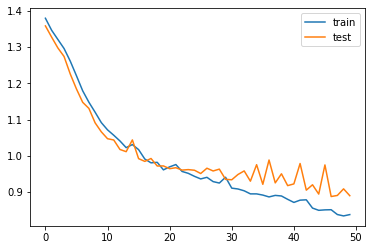

In [149]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()                       

In [150]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

In [151]:
print(accuracy)

0.632478654384613


#### 하순

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
X_하순_가전제품, Y_하순_가전제품, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [44]:
#masking layer 추가(https://stackoverflow.com/questions/49670832/keras-lstm-with-masking-layer-for-variable-length-inputs)
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(64,input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation= 'relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr= 0.001, rho = 0.9), metrics=['acc', recall_m])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_9 (Masking)          (None, 5000, 19)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                21504     
_________________________________________________________________
dense_25 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 34        
Total params: 24,146
Trainable params: 24,146
Non-trainable params: 0
__________________________________________________

In [45]:
history = model.fit(X_train, y_train, epochs=60, batch_size=500, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 735 samples, validate on 315 samples
Epoch 1/60
 - 14s - loss: 0.4634 - acc: 0.9456 - recall_m: 0.9536 - val_loss: 0.2975 - val_acc: 0.9429 - val_recall_m: 0.9429
Epoch 2/60
 - 13s - loss: 0.2881 - acc: 0.9605 - recall_m: 0.9565 - val_loss: 0.2485 - val_acc: 0.9429 - val_recall_m: 0.9429
Epoch 3/60
 - 13s - loss: 0.2290 - acc: 0.9605 - recall_m: 0.9575 - val_loss: 0.2319 - val_acc: 0.9429 - val_recall_m: 0.9429
Epoch 4/60
 - 13s - loss: 0.1996 - acc: 0.9605 - recall_m: 0.9575 - val_loss: 0.2285 - val_acc: 0.9429 - val_recall_m: 0.9429
Epoch 5/60
 - 13s - loss: 0.1920 - acc: 0.9605 - recall_m: 0.9575 - val_loss: 0.2279 - val_acc: 0.9429 - val_recall_m: 0.9429
Epoch 6/60
 - 12s - loss: 0.1868 - acc: 0.9605 - recall_m: 0.9575 - val_loss: 0.2290 - val_acc: 0.9429 - val_recall_m: 0.9429
Epoch 7/60
 - 13s - loss: 0.1861 - acc: 0.9605 - recall_m: 0.9575 - val_loss: 0.2324 - val_acc: 0.9429 - val_recall_m: 0.9429
Epoch 8/60
 - 12s - loss: 0.1816 - acc: 0.9605 - recall_m: 0.9575 - val_

In [ ]:
train_df = pd.DataFrame(X_train.reshape(X_train.shape[0] * X_train.shape[1], 19))
train_df.columns = ['세션당 방문사이트수','세션지속시간','쇼핑사이트방문여부' ,
                    '게임', '경제/재테크', '교육/학교', '기타', '뉴스/미디어', '문화/예술', '비즈니스/쇼핑', '생활/건강', '스포츠/레저',
 '여행/세계정보', '연예/오락', '인물', '정치/사회', '종교', '컴퓨터/인터넷', '학문/사전']
## Sensitivity Analysis
importance_df = pd.DataFrame(np.zeros((19, 2)), columns=['varible_name', 'perturbation_effect'])
def var_importance(model):
    x = X_test # Get a sample of data
    orig_out = model.predict(x)
    for i in range(19):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5 #RMSE
        importance_df.iloc[i,0] = train_df.columns[i]
        importance_df.iloc[i,1] = effect
        #print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
var_importance(model)
importance_df = importance_df.sort_values(by='perturbation_effect', ascending=False)
print(importance_df)

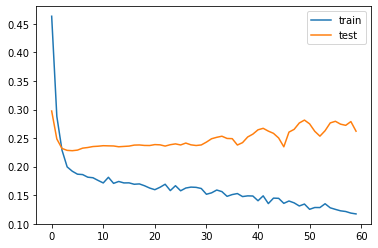

In [46]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()                                       
plt.show()       